<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test</a></span></li></ul></div>

#  Taxi Order Forecasting

The company Taxi collected historical data on taxi orders at airports. To attract more drivers during peak hours, it is necessary to forecast the number of taxi orders for the next hour. A model was built for this prediction. The RMSE metric on the test dataset must not exceed 48.


## Preparation

In this section, the following steps will be carried out:
 - Load all required modules and libraries
 - Load the data and convert temporal data to the correct type
 - Check the dataset for missing values
 - Check the dataset for duplicates
 - Convert the zero column into an index

In [1]:
# LOADING MODULES AND LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split

# Loading required models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


# Model for trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

In [2]:
# Metrics
from sklearn.metrics import mean_squared_error
rmse=lambda y_actual, y_predicted: mean_squared_error(y_actual, y_predicted, squared=False)

In [3]:
# LOADING DATA
df=pd.read_csv(r"", parse_dates=[0])#сразу изменен тип данных

In [4]:
# MISSING VALUES AND DUPLICATES IN DATA
df.info()
display(df.head(5))
print('Количество дубликатов в датафрейме равно', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Количество дубликатов в датафрейме равно 0


In [5]:
# CHANGING THE INDEX
df=df.set_index('datetime')
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Results: 
 - Data loaded, temporal fields converted to the correct type
 - The dataset represents a time series (historical data on taxi orders at airports)
 - No missing values or duplicates found
 - The datetime column was set as the index

## Analysis

In this section, the following steps will be carried out:
 - Resampling by one hour
 - Adding and analyzing features (rolling window method, trend and seasonality, stationarity)

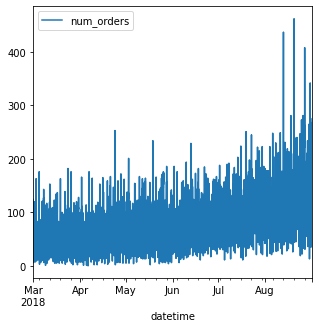

In [7]:
# RESAMPLING BY 1 HOUR 
df = df.resample('1H').sum()# Total orders per hour
df.plot();

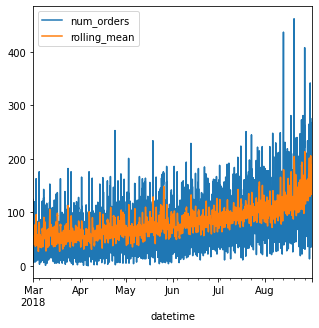

In [8]:
# TREND ANALYSIS USING MOVING WINDOW
df['rolling_mean'] = df.rolling(10).mean()# value 10 selected experimentally
df.plot();

Text(0.5, 1.0, 'Trend')

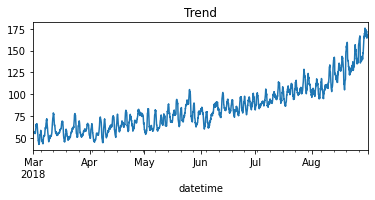

In [10]:
# YEARLY TREND 
# Trend – by summer the number of orders increases. 
decomposed = seasonal_decompose(df['num_orders'])# The original time series is passed to the function  
# Trend visualization 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Text(0.5, 1.0, 'Trend')

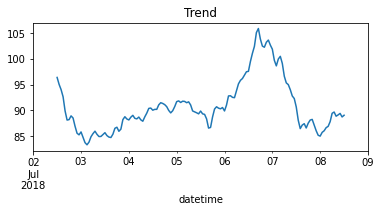

In [11]:
# WEEKLY TREND 
# Trend – on weekends the number of orders increases. People take taxis for leisure trips.  
decomposed = seasonal_decompose(df['2018-07-02 00:00:00': '2018-07-09 00:00:00']['num_orders'])
plt.figure(figsize=(6, 8))
# Trend Visualization
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

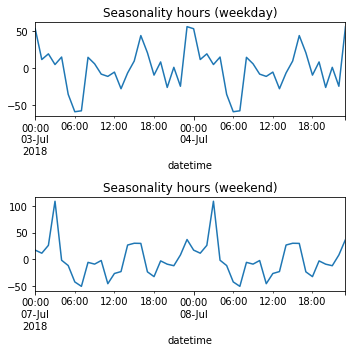

In [12]:
# DAILY SEASONALITY
# Although seasonality differs slightly depending on the type of day (weekends or weekdays), the minima and maxima generally coincide.
# People tend to order taxis more often in the morning, at lunchtime, and in the evening.
decomposed_weekday = seasonal_decompose(df['2018-07-03 00:00:00': '2018-07-04 23:59:59']['num_orders'])
decomposed_weekend = seasonal_decompose(df['2018-07-07 00:00:00': '2018-07-08 23:59:59']['num_orders'])
plt.subplot(211)
decomposed_weekday.seasonal.plot()
plt.title('Seasonality hours (weekday)')
# Visualization of weekend seasonality by hours
plt.subplot(212)
decomposed_weekend.seasonal.plot()
plt.title('Seasonality hours (weekend)')
plt.tight_layout()

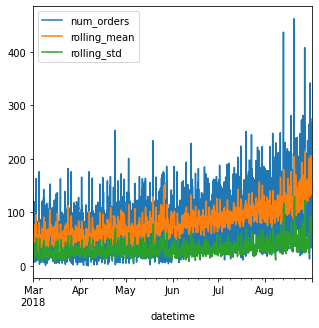

In [13]:
# CHECK FOR STATIONARITY
# The mean and standard deviation change (increase in summer), the series is non-stationary
df['rolling_std'] = df['num_orders'].rolling(10).std()
df.plot();

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,0.0,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,NaN
2018-03-01 03:00:00,-5.0,NaN,NaN
2018-03-01 04:00:00,-23.0,NaN,NaN


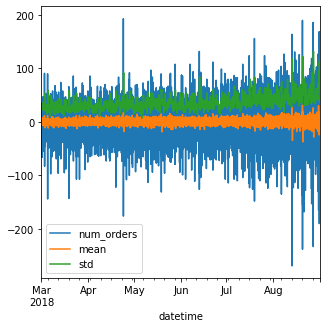

In [14]:
# Transforming the series to make it more stationary.
# However, since the trend is already linear, this step is not mandatory.
df2=(df['num_orders']-df['num_orders'].shift()).fillna(0).to_frame()# Difference
df2['mean'] = df2.num_orders.rolling(10).mean()
df2['std'] = df2.num_orders.rolling(10).std()
display(df2.head(5))
df2.plot();

RESULTS:
 - The time series was resampled by hour.
 - Then, the main trend was analyzed using a moving window of size 50. The average number of taxi orders per hour was calculated. It is noticeable that in summer the number of orders increases, apparently because people tend to travel more during the warm season.
 - The data covers only one year, so seasonality is not observed, only the trend. However, to avoid relying solely on visual inspection, the trend, seasonality, and noise were visualized. This analysis confirms the absence of seasonality.
 - Since the mean and the standard deviation change over time, the time series is not stationary. However, as the trend is already linear, applying differencing to the time series does not provide much benefit. This can also be seen in the differenced series plots: although the new series became more stationary, the trend itself did not change.


## Training

In this chapter, we will:
- Create additional features using a function and assemble the final dataset
- Split the data into training and test sets (the test set will be 10% of the data)
- First, forecast the time series without training (using two approaches: 1) all values are predicted by the median, 2) the next value is predicted by the previous value of the series)
- Then, train different models: linear regression and decision tree with various hyperparameters.


In [15]:
# DATASET FOR MODELING
df_final=df.drop(columns=['rolling_std'])
df_final.head()

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN


In [17]:
# CREATING ADDITIONAL FEATURES
def make_features(df_final, max_lag, rolling_mean_size):
    df_final['dayofweek'] = df_final.index.dayofweek
    df_final['hour'] = df_final.index.hour
    
    for lag in range(1, max_lag + 1):
        df_final['lag_{}'.format(lag)] = df_final['num_orders'].shift(lag)

    df_final['rolling_mean'] = df_final['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df_final, 1, 10)
df_final.head()

,num_orders,rolling_mean,dayofweek,hour,lag_1
datetime,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0
2018-03-01 02:00:00,71,NaN,3,2,85.0
2018-03-01 03:00:00,66,NaN,3,3,71.0
2018-03-01 04:00:00,43,NaN,3,4,66.0


In [18]:
# TRAIN-TEST SPLIT
train, test = train_test_split(df_final, shuffle=False, test_size=0.1)
# Displaying values to verify the correctness of the split. The train set should precede the test set.
print('train_min', train.index.min(), 'train_max', train.index.max())
print('test_min', test.index.min(), 'test_max', test.index.max())

train_min 2018-03-01 00:00:00 train_max 2018-08-13 13:00:00
test_min 2018-08-13 14:00:00 test_max 2018-08-31 23:00:00


In [19]:
# SPLITTING INTO FEATURES AND TARGET
train = train.dropna()
X_train = train.drop(columns='lag_1')
y_train = train['lag_1']
X_test = test.drop(columns='lag_1')
y_test = test['lag_1']

In [20]:
# FORECAST WITHOUT TRAINING
print("Среднее количество вызовов таки в час:", y_test.mean())

pred_median = np.ones(y_test.shape) * y_train.median()
print("RMSE:", rmse(pred_median, y_test))

pred_previous = y_test.shift()
pred_previous.iloc[0] =  y_train.iloc[-1] # for filling the first value
print("RMSE:", mean_squared_error(pred_previous, y_test, squared=False))

Среднее количество вызовов таки в час: 139.36199095022624
RMSE: 86.95832985529172
RMSE: 58.864269828508355


In [23]:
# PIPELINE
pipe_final = Pipeline(
    [
        ("models", DummyRegressor(strategy='mean')),
    ]
)

In [24]:
# DICTIONARY OF MODELS WITH HYPERPARAMETERS
param_grid = [
    
    {
        "models": [DecisionTreeRegressor(random_state=42)],
        "models__max_depth": range(2, 15),
        'models__min_samples_split': range(2, 8),
        'models__min_samples_leaf': range(1,6),
        'models__max_features': range(1, 5),
    },
    
    {
        "models": [LinearRegression()],
    }
]

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring="neg_root_mean_squared_error",
    error_score='raise',
    random_state=42,
    cv=tscv,  
)

In [27]:
randomized_search.fit(X_train, y_train) # TRAINING
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучшее значение метрики:\n\n', abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 DecisionTreeRegressor(max_depth=10, max_features=3,
                                       min_samples_leaf=5, random_state=42))])
Лучшее значение метрики:

 27.024145947423115


RESULTS:

 - It is possible that when forecasting time series, the correct creation of additional features plays a greater role, as well as the proper choice of lag or moving window. The larger the window, the better the training results will be. If these manipulations do not distort the data, then it may be more worthwhile to focus on tuning the parameters of the make_features function rather than on hyperparameter tuning across different models.

 - According to the results, the best model is the decision tree with hyperparameters: max_depth=10, max_features=3, min_samples_leaf=5. The cross-validation metric is RMSE=24.8


## Test

In this chapter:
- The data will be evaluated on the test set. The RMSE metric on the test set should not exceed 48. Conclusions will be drawn.


In [30]:
# FORECAST OF THE BEST MODEL ON THE TEST SET
y_pred = randomized_search.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {rmse(y_test, y_pred)}')

Метрика RMSE на тестовой выборке: 43.13539661510642


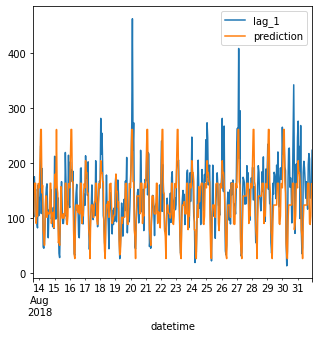

In [31]:
analysis=y_test.to_frame()
analysis['prediction']=y_pred
analysis.plot();

CONCLUSIONS OF THE ANALYSIS:
 - According to the results, the best model on the test set showed an error of RMSE=43.13. This satisfies the condition RMSE < 48. The plot shows that the prediction represents a more stationary series than the test data. This means that the prediction captures only the obvious trends and may miss some details. However, there are also fewer spikes in the prediction.


PROJECT CONCLUSIONS:
 - In the preparation chapter, the data was loaded and checked for missing values, duplicates, and correct data types.
 - In the analysis chapter, the time series was analyzed using a moving window method, the trend and seasonality were examined, and the series was tested for stationarity.
 - In the training chapter, additional features were created using a function and the final dataset was assembled. This step had a significant impact on the final result. The data was split into training and test sets in a 4-to-1 ratio. Time series were first forecast without training; however, the error was too high (RMSE=256). Then, linear regression and decision tree models with various hyperparameters were trained. The linear regression model was chosen as the final one. RMSE on the test set was 7.25, which meets the condition. The prediction plots show a continuing upward trend in taxi orders. From this, it can be concluded that the number of cars can be increased and the fare prices raised in the near future.
